In [50]:
# DATA CLEANING
import pandas as pd
df = pd.read_csv('events.csv')

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

from datetime import datetime
df['date'] = df['timestamp'].apply(lambda x: datetime.fromtimestamp(x/1000))
df.head()

,timestamp,visitorid,event,itemid,transactionid,date
0,1433221332117,257597,view,355908,NaN,2015-06-02 07:02:12.117
1,1433224214164,992329,view,248676,NaN,2015-06-02 07:50:14.164
2,1433221999827,111016,view,318965,NaN,2015-06-02 07:13:19.827
3,1433221955914,483717,view,253185,NaN,2015-06-02 07:12:35.914
4,1433221337106,951259,view,367447,NaN,2015-06-02 07:02:17.106


In [64]:
# DATASET TRANSACTIONS
# Diviser les events entre transactions et le reste
non_transactions = df.loc[df.event != "transaction"]
transactions = df.loc[df.event == "transaction"]

# Merger les deux tableaux afin de calculer le temps passé entre 2 actions successives
inner_merged_total = pd.merge(transactions, non_transactions, on=["visitorid"], how="inner")

# Trier le dataframe par visitorid...
inner_merged_total = inner_merged_total.sort_values(by=['visitorid','date_x','date_y','itemid_x'])

# time_diff est moins de 24h et le itemid sur lequel la transaction 
# a eu lieu et le itemid sur lequel chaque événement s'est produit doivent être les mêmes
inner_merged_total['event_diff_second'] = inner_merged_total['date_x'] - inner_merged_total['date_y']
inner_merged_total['event_diff_second'] = inner_merged_total['event_diff_second'] / np.timedelta64(1, 's')

transaction_24h = inner_merged_total.loc[inner_merged_total['event_diff_second'] < 86400]
transaction_made_24h = transaction_24h.loc[inner_merged_total['itemid_x'] == inner_merged_total['itemid_y']]

# Supprimer certaines colonnes
transaction_made_24h = transaction_made_24h.drop(['timestamp_x','timestamp_y','transactionid_y'], axis=1)
transaction_made_24h

#transaction_made_24h.loc[transaction_made_24h.transactionid_x == 9725]

,visitorid,event_x,itemid_x,transactionid_x,date_x,event_y,itemid_y,date_y,event_diff_second
10069099,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,view,465522,2015-08-15 03:06:38.438,1342.792
10069108,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,addtocart,465522,2015-08-15 03:13:39.691,921.539
10069105,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,addtocart,465522,2015-08-15 03:13:48.324,912.906
10069098,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,view,465522,2015-08-15 03:27:09.037,112.193
10069106,172,transaction,465522,9725.0,2015-08-15 03:29:01.230,view,465522,2015-08-15 03:27:27.421,93.809
...,...,...,...,...,...,...,...,...,...
9743949,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,view,360922,2015-08-05 00:57:13.885,851.739
9743946,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,view,360922,2015-08-05 01:00:26.861,658.763
9743942,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,view,360922,2015-08-05 01:03:14.670,490.954
9743943,1407110,transaction,360922,3851.0,2015-08-05 01:11:25.624,addtocart,360922,2015-08-05 01:05:35.724,349.900


In [98]:
# Grouper par le transactionid et la date d'evenement
calcul_time = pd.DataFrame(transaction_made_24h,columns=['transactionid_x','visitorid','date_y'])
calcul_time['time_diff_sec'] = calcul_time.sort_values(['transactionid_x','date_y']).groupby('transactionid_x')['date_y'].diff()
calcul_time['time_diff_sec'] = calcul_time['time_diff_sec'] / np.timedelta64(1, 's')
calcul_time['time_diff_sec'] = calcul_time['time_diff_sec'].fillna(0)

# VERIFICATION
calcul_time.loc[calcul_time.transactionid_x == 11345]
#group_time = calcul_time.groupby('transactionid_x')
#group_time.get_group(11345)

calcul_mean_time = calcul_time.groupby(by=['transactionid_x']).mean()
calcul_mean_time = calcul_mean_time.rename(columns={"time_diff_sec": "mean_time_second"})
calcul_mean_time = calcul_mean_time.fillna(0)
#calcul_mean_time.loc[calcul_mean_time.mean_time_second < 0]

time_1_event = calcul_mean_time.loc[calcul_mean_time.mean_time_second == 0]
time_1_event = pd.merge(time_1_event, transaction_made_24h, on=["transactionid_x"], how="left")
time_1_event = pd.DataFrame(time_1_event,columns=['transactionid_x','event_diff_second']).set_index('transactionid_x')
time_1_event = time_1_event.rename(columns={"event_diff_second": "mean_time_second"})
time_1_event = time_1_event.loc[time_1_event.mean_time_second > 0]

# Créer le tableau final du temps moyen par transaction en combiant les deux tableaux ci-dessus
time_mean_transaction = time_1_event.combine_first(calcul_mean_time)
time_mean_transaction['mean_time_minute'] = round(time_mean_transaction['mean_time_second']/60)
time_mean_transaction['mean_time_hour'] = round(time_mean_transaction['mean_time_second']/3600,2)

# Ajouter item list
aggregation = {'itemid': list}
item_list_transaction = df.groupby(['transactionid']).agg(aggregation)
time_mean_transaction['item_list'] = item_list_transaction['itemid']

time_mean_transaction.sort_values('mean_time_minute', ascending=True)

,mean_time_second,visitorid,mean_time_minute,mean_time_hour,item_list
transactionid_x,,,,,
10645.0,4.898500e+00,986413.0,0.0,0.00,"[335930, 147307]"
4109.0,4.845000e-01,861299.0,0.0,0.00,[358188]
4108.0,1.579400e+01,1093035.0,0.0,0.00,[16417]
4107.0,6.012667e+00,775282.0,0.0,0.00,[89044]
4106.0,3.985000e-01,890980.0,0.0,0.00,[191203]
...,...,...,...,...,...
6481.0,2.443976e+06,1082305.0,40733.0,678.88,[165080]
16019.0,2.506030e+06,1042112.0,41767.0,696.12,"[450216, 23250]"
1183.0,2.905478e+06,824842.0,48425.0,807.08,[133907]


In [97]:
#### NO TRAITEMENT ZERO MOINS
# Calculer le temps moyen
calcul_mean_time = calcul_time.groupby(by=['transactionid_x']).mean()
calcul_mean_time = calcul_mean_time.rename(columns={"time_diff_sec": "mean_time_second"})
calcul_mean_time = calcul_mean_time.fillna(0)

time_1_event = calcul_mean_time.loc[calcul_mean_time.mean_time_second == 0]
time_1_event = pd.merge(time_1_event, transaction_made_24h, on=["transactionid_x"], how="left")
time_1_event = pd.DataFrame(time_1_event,columns=['transactionid_x','event_diff_second']).set_index('transactionid_x')
time_1_event = time_1_event.rename(columns={"event_diff_second": "mean_time_second"})

# Créer le tableau final du temps moyen par transaction en combiant les deux tableaux ci-dessus
time_mean_transaction = time_1_event.combine_first(calcul_mean_time)
time_mean_transaction['mean_time_minute'] = round(time_mean_transaction['mean_time_second']/60)
time_mean_transaction['mean_time_hour'] = round(time_mean_transaction['mean_time_second']/3600,2)

# Ajouter item list
aggregation = {'itemid': list}
item_list_transaction = df.groupby(['transactionid']).agg(aggregation)
time_mean_transaction['item_list'] = item_list_transaction['itemid']


time_mean_transaction.sort_values('mean_time_minute', ascending=True)

,mean_time_second,visitorid,mean_time_minute,mean_time_hour,item_list
transactionid_x,,,,,
11345.0,-3.026679e+06,668775.0,-50445.0,-840.74,[3563]
6125.0,-1.034215e+06,975683.0,-17237.0,-287.28,[360877]
8650.0,-9.473625e+05,518659.0,-15789.0,-263.16,[166358]
6752.0,-3.230025e+05,1096542.0,-5383.0,-89.72,[196177]
15537.0,-2.004159e+05,972040.0,-3340.0,-55.67,"[194165, 200056, 431276, 347113]"
...,...,...,...,...,...
6481.0,2.443976e+06,1082305.0,40733.0,678.88,[165080]
16019.0,2.506030e+06,1042112.0,41767.0,696.12,"[450216, 23250]"
1183.0,2.905478e+06,824842.0,48425.0,807.08,[133907]


In [99]:
# Calculer le temps moyen sur transaction par acheteur
time_mean_visitor = time_mean_transaction.groupby(by=['visitorid']).mean()
time_mean_visitor

# Nombre de visites
stats = df.groupby('visitorid').agg({'visitorid':'count'})
stats = stats.rename(columns={"visitorid": "nb_visites"})

# Nombre de views par visitorid
view = df.loc[df['event'] == 'view'].groupby('visitorid').agg({'visitorid':'count'})
view = view.rename(columns={"visitorid": "nb_views"})

# Nombre de addtocarts par visitorid
addtocart = df.loc[df['event'] == 'addtocart'].groupby('visitorid').agg({'visitorid':'count'})
addtocart = addtocart.rename(columns={"visitorid": "nb_addtocarts"})

#### STATS PAR VISITEUR #####
# Nombre de transactions par visitorid
transaction = df.loc[df['event']=='transaction'].groupby(by=['visitorid','transactionid'], as_index=False).agg({'itemid': 'count'})
all_transaction=transaction.groupby(by='visitorid').agg({'transactionid': 'count'}).rename(columns={"transactionid": "nb_transactions"})

# Merge les dataframes
stats = pd.merge(stats, view, left_index=True, right_index=True, how='left')
stats = pd.merge(stats, addtocart, left_index=True, right_index=True, how='left')
stats = pd.merge(stats, all_transaction, left_index=True, right_index=True, how='left')

# Merge items
items = df.loc[df['transactionid'] > 0].groupby(by='visitorid').agg({'itemid': 'count'})
stats = pd.merge(stats, items, left_index=True, right_index=True, how='left')
stats = stats.rename(columns={"itemid": "nb_items_bought"})

# Merge avec temps moyen passé
stats = pd.merge(stats, time_mean_visitor, left_index=True, right_index=True, how='left')
stats = stats.fillna(0)
stats = stats.sort_values('nb_transactions', ascending=False)

# Supprimer le visiteur 1150086
stats = stats.drop(stats.head(1).index)
stats = stats.sort_values('mean_time_minute', ascending=True)
stats

,nb_visites,nb_views,nb_addtocarts,nb_transactions,nb_items_bought,mean_time_second,mean_time_minute,mean_time_hour
visitorid,,,,,,,,
1174714,3,3.0,0.0,0.0,0.0,0.000000e+00,0.0,0.00
5402,1,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.00
5403,1,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.00
5404,1,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.00
5405,1,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.00
...,...,...,...,...,...,...,...,...
663210,7,5.0,1.0,1.0,1.0,1.884945e+06,31416.0,523.60
861356,6,4.0,1.0,1.0,1.0,2.062957e+06,34383.0,573.04
1058213,19,11.0,5.0,1.0,3.0,2.164901e+06,36082.0,601.36


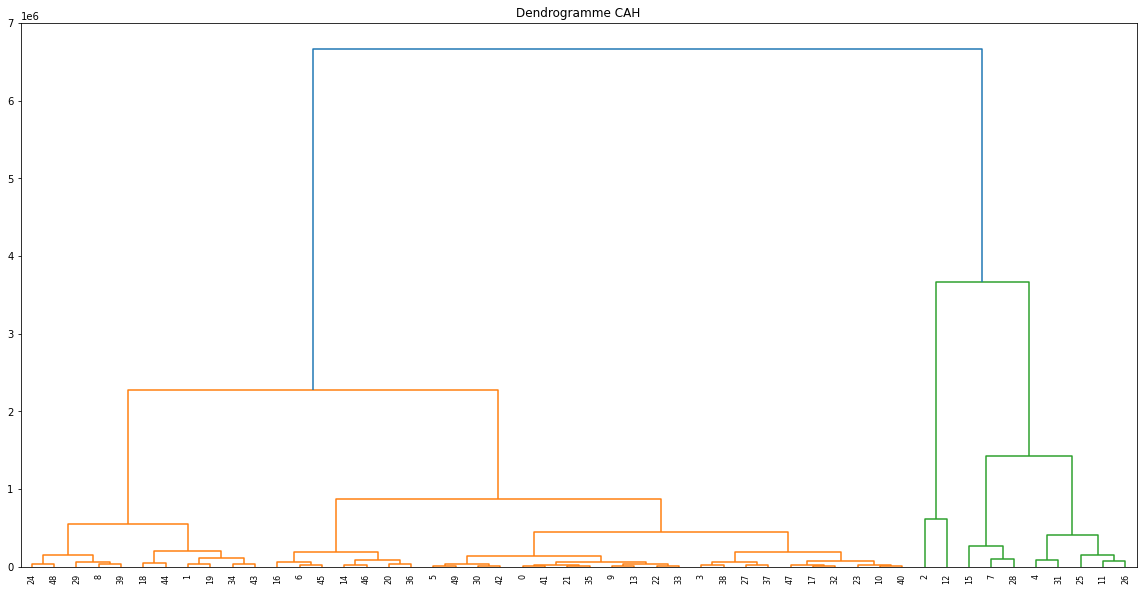

/Users/sooyounglee/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


,nb_visites,nb_views,nb_addtocarts,nb_transactions,nb_items_bought,mean_time_second,mean_time_minute,mean_time_hour,kmean1_label,agglo_label,kmean2_label
visitorid,,,,,,,,,,,
1174714,3,3.0,0.0,0.0,0.0,0.000000e+00,0.0,0.00,0,0.0,0
5402,1,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.00,0,0.0,0
5403,1,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.00,0,0.0,0
5404,1,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.00,0,0.0,0
5405,1,1.0,0.0,0.0,0.0,0.000000e+00,0.0,0.00,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
663210,7,5.0,1.0,1.0,1.0,1.884945e+06,31416.0,523.60,15,1.0,1
861356,6,4.0,1.0,1.0,1.0,2.062957e+06,34383.0,573.04,28,1.0,1
1058213,19,11.0,5.0,1.0,3.0,2.164901e+06,36082.0,601.36,7,1.0,1


In [100]:
# CLUSTERING SUR STATS

k1 = KMeans(n_clusters=50).fit(stats)
plt.figure(figsize=(20, 10))
Z = linkage(k1.cluster_centers_, method='ward', metric='euclidean')
plt.title("Dendrogramme CAH")
dendrogram(Z, leaf_rotation=90.)
plt.show()

# AGGLOMERATIVECLUSTERING PAR 3
ac = AgglomerativeClustering(n_clusters = 3).fit(k1.cluster_centers_)
cd = pd.DataFrame(k1.cluster_centers_)

stats['kmean1_label'] = k1.labels_

# DATA CLUSTERING    
for i in list(cd.index):
    stats.loc[stats['kmean1_label'] == cd.index[i], 'agglo_label'] = ac.labels_[i]

# GET NEW CENTROIDS = MEAN OF AGGLO 4 LABELS
new_centroids = stats.groupby('agglo_label').mean()
new_stats = stats.drop(['agglo_label'], axis=1)

k2 = KMeans(n_clusters=3, init=new_centroids)
k2.fit(new_stats)

# Centroids and labels
k2_centroids = k2.cluster_centers_
k2_labels = k2.labels_

stats['kmean2_label'] = k2.labels_
stats

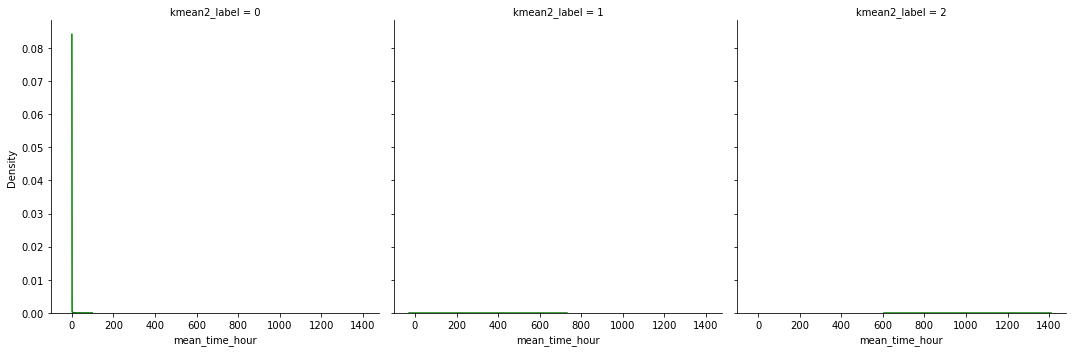

In [101]:
sns.displot(data=stats, x="mean_time_hour", col="kmean2_label", kind="kde", color='green')


Text(0.5, 1.0, "Le nombre d'ajouts aux paniers par visiteur")

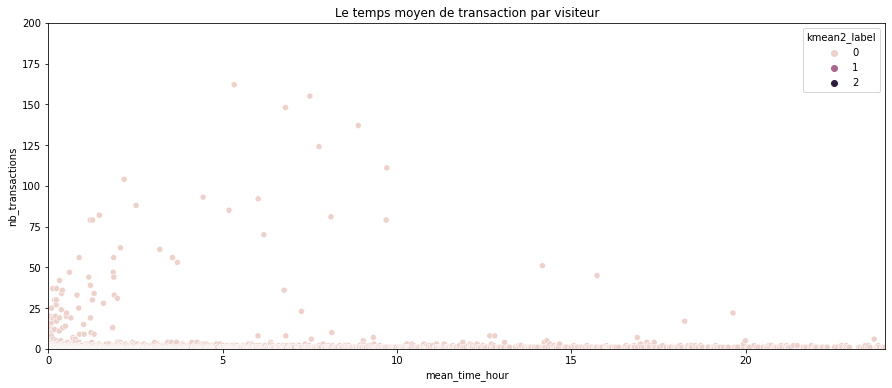

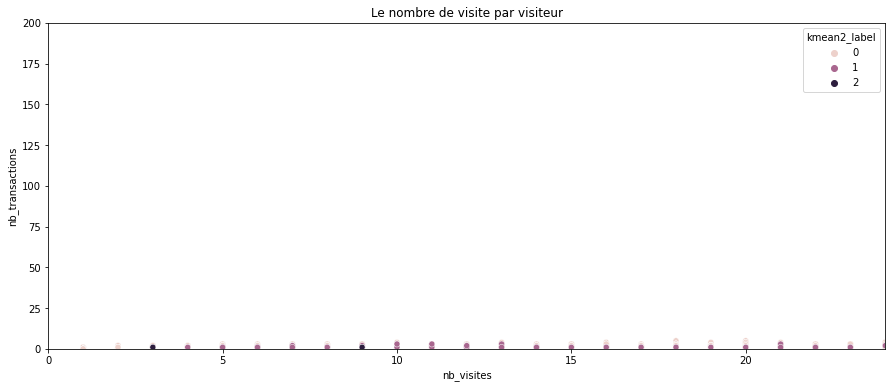

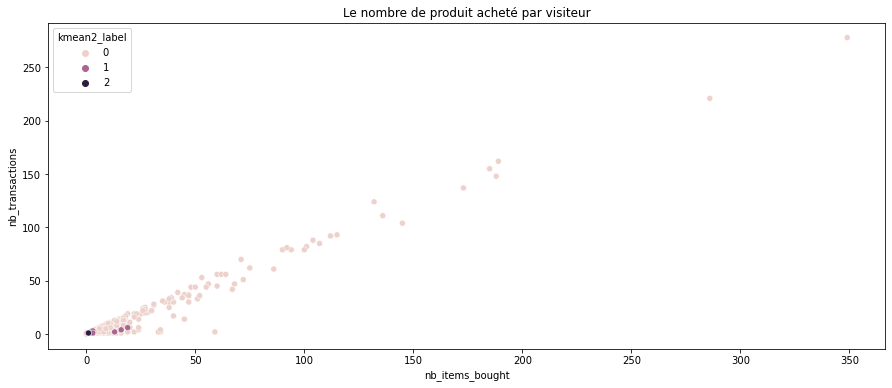

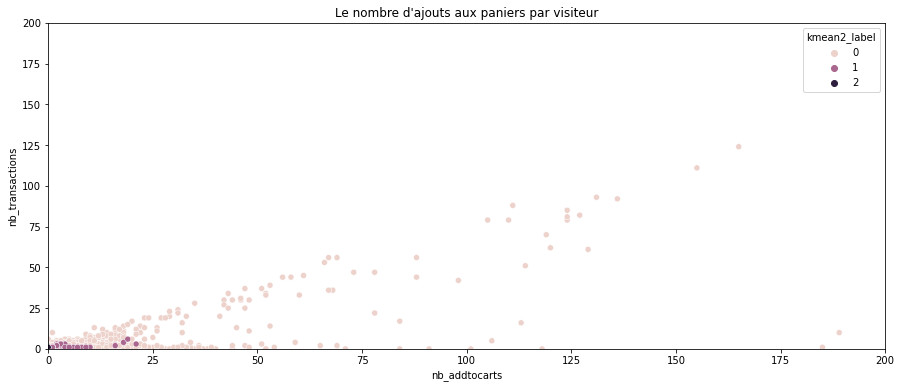

In [102]:
##### ANALYSES TABELEAU STATS (PAR VISITEUR)
plt.figure(figsize=(15,6))
sns.scatterplot(data=stats, x="mean_time_hour", y="nb_transactions", hue="kmean2_label")
plt.xlim(0, 24)
plt.ylim(0, 200)
plt.title('Le temps moyen de transaction par visiteur')

plt.figure(figsize=(15,6))
sns.scatterplot(data=stats, x="nb_visites", y="nb_transactions", hue="kmean2_label")
plt.xlim(0, 24)
plt.ylim(0, 200)
plt.title('Le nombre de visite par visiteur')

plt.figure(figsize=(15,6))
sns.scatterplot(data=stats, x="nb_items_bought", y="nb_transactions", hue="kmean2_label")
#plt.xlim(0, 24)
#plt.ylim(0, 600)
plt.title('Le nombre de produit acheté par visiteur')

plt.figure(figsize=(15,6))
sns.scatterplot(data=stats, x="nb_addtocarts", y="nb_transactions", hue="kmean2_label")
plt.xlim(0, 200)
plt.ylim(0, 200)
plt.title("Le nombre d'ajouts aux paniers par visiteur")

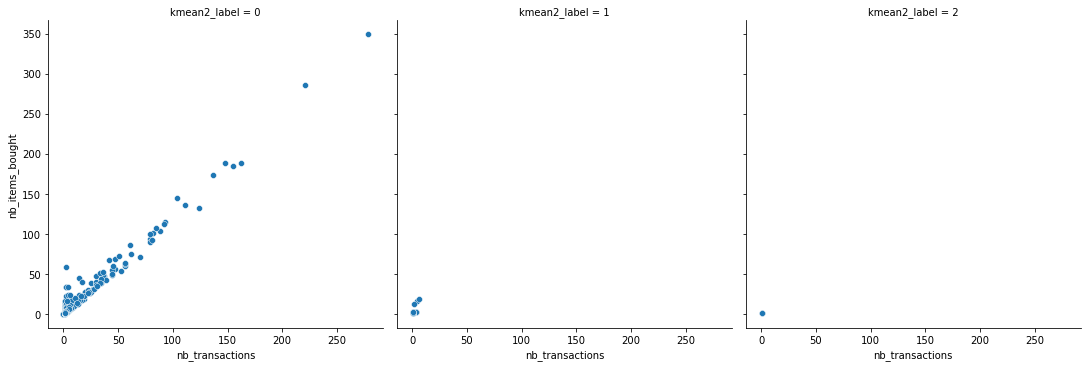

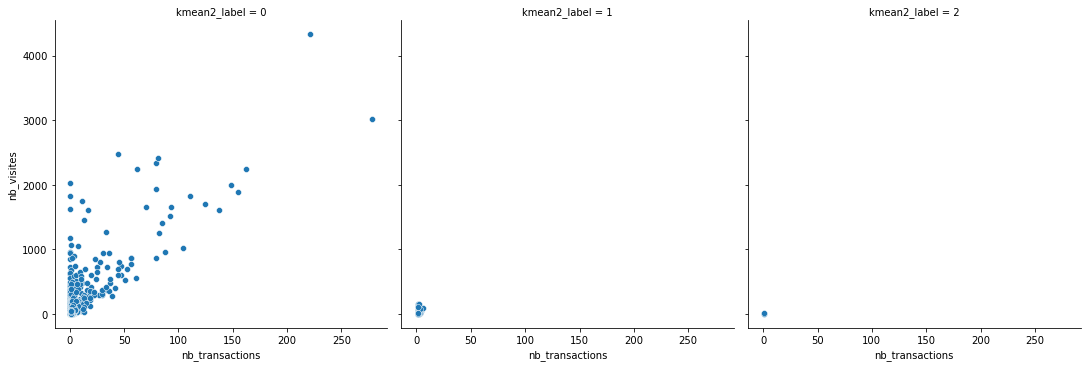

In [103]:
sns.relplot(
    data=stats, x="nb_transactions", y="nb_items_bought",
    col="kmean2_label",
    kind="scatter"
)

sns.relplot(
    data=stats, x="nb_transactions", y="nb_visites",
    col="kmean2_label",
    kind="scatter"
)

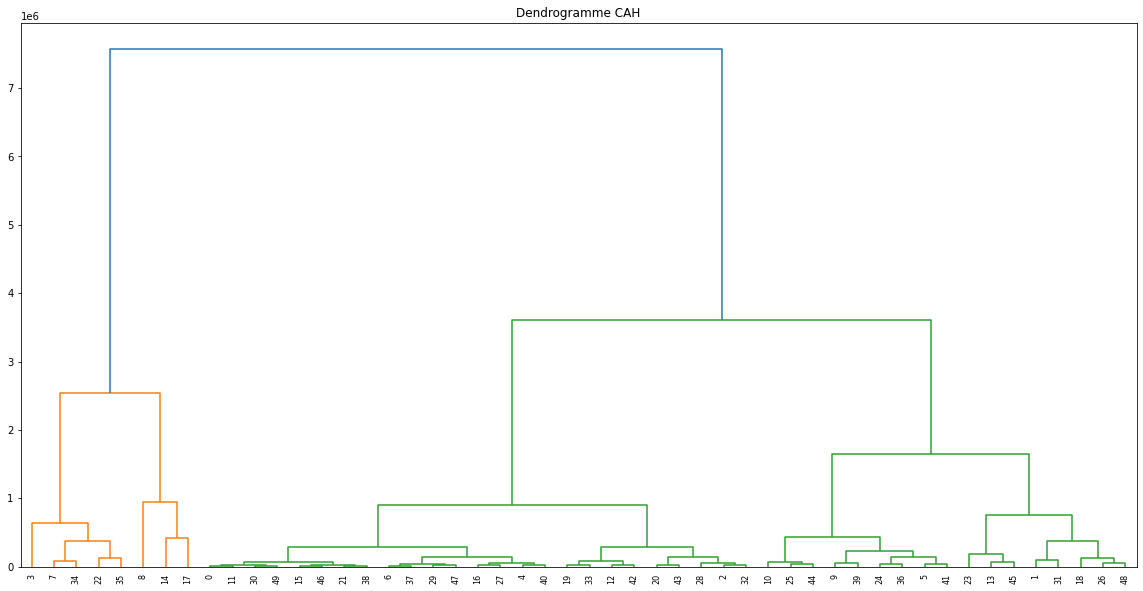

/Users/sooyounglee/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1035: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


,mean_time_second,mean_time_minute,mean_time_hour,kmean1_label,agglo_label,kmean2_label
transactionid_x,,,,,,
0.0,309383.453000,5156.0,85.94,42,2.0,1
1.0,198186.988750,3303.0,55.05,4,2.0,2
2.0,189.096000,3.0,0.05,0,2.0,2
4.0,29743.228500,496.0,8.26,15,2.0,2
6.0,2.566500,0.0,0.00,0,2.0,2
...,...,...,...,...,...,...
17667.0,13758.819200,229.0,3.82,49,2.0,2
17668.0,12.996000,0.0,0.00,0,2.0,2
17669.0,145540.993167,2426.0,40.43,27,2.0,2


In [104]:
# CLUSTERING SUR time_mean_transaction
time_mean_transaction_clustering = time_mean_transaction.drop(['item_list','visitorid'], axis=1)

# CLUSTERING SUR time_mean_transaction_clustering

k1 = KMeans(n_clusters=50).fit(time_mean_transaction_clustering)
plt.figure(figsize=(20, 10))
Z = linkage(k1.cluster_centers_, method='ward', metric='euclidean')
plt.title("Dendrogramme CAH")
dendrogram(Z, leaf_rotation=90.)
plt.show()

# AGGLOMERATIVECLUSTERING PAR 3
ac = AgglomerativeClustering(n_clusters = 3).fit(k1.cluster_centers_)
cd = pd.DataFrame(k1.cluster_centers_)

time_mean_transaction_clustering['kmean1_label'] = k1.labels_

# DATA CLUSTERING    
for i in list(cd.index):
    time_mean_transaction_clustering.loc[time_mean_transaction_clustering['kmean1_label'] == cd.index[i], 'agglo_label'] = ac.labels_[i]

# GET NEW CENTROIDS = MEAN OF AGGLO 4 LABELS
new_centroids = time_mean_transaction_clustering.groupby('agglo_label').mean()
new_time_mean_transaction_clustering = time_mean_transaction_clustering.drop(['agglo_label'], axis=1)

k2 = KMeans(n_clusters=3, init=new_centroids)
k2.fit(new_time_mean_transaction_clustering)

# Centroids and labels
k2_centroids = k2.cluster_centers_
k2_labels = k2.labels_

time_mean_transaction_clustering['kmean2_label'] = k2.labels_
time_mean_transaction_clustering

Text(0.5, 1.0, 'Clustering')

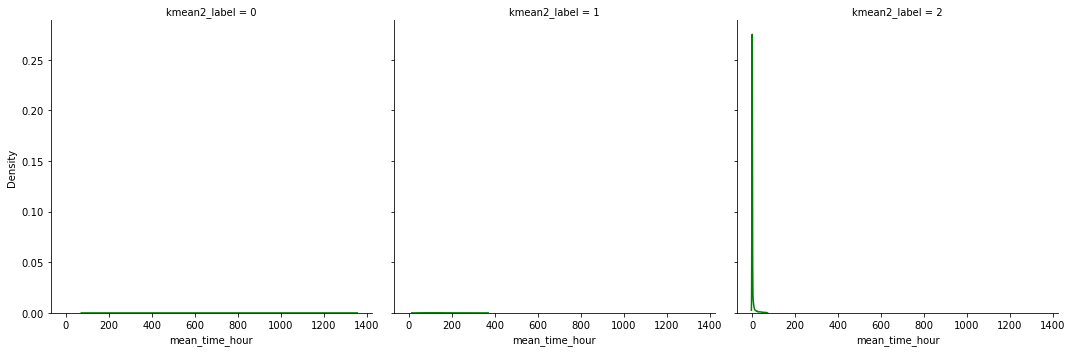

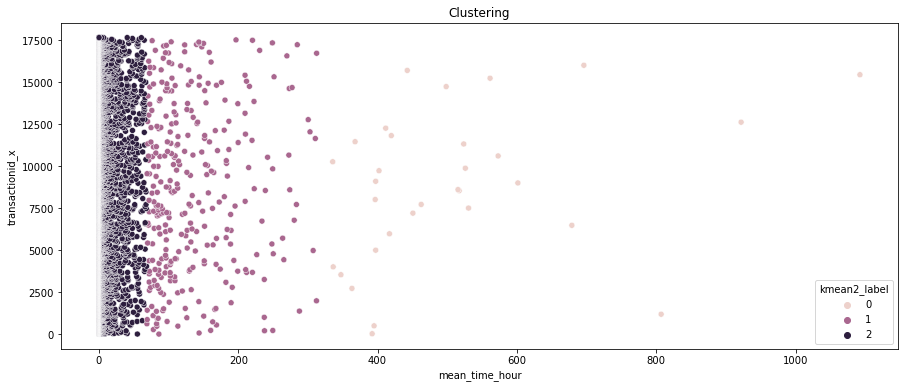

In [105]:
sns.displot(data=time_mean_transaction_clustering, x="mean_time_hour", col="kmean2_label", kind="kde", color='green')

import seaborn as sns
plt.figure(figsize=(15,6))
sns.scatterplot(data=time_mean_transaction_clustering, x="mean_time_hour", y=time_mean_transaction_clustering.index, hue="kmean2_label",)
plt.title('Clustering')

Text(0.5, 1.0, 'Temps moyens passé avant la transaction compris égale à moins de 10 minutes')

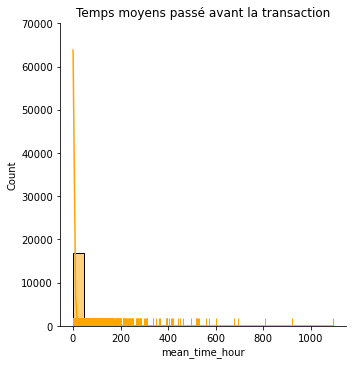

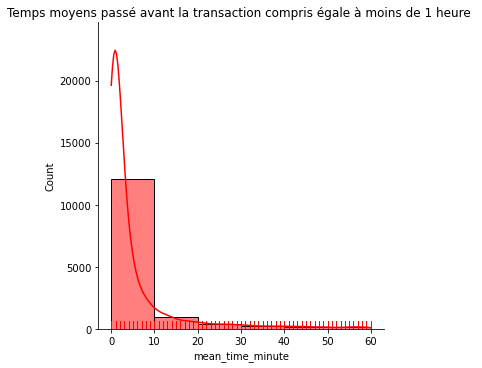

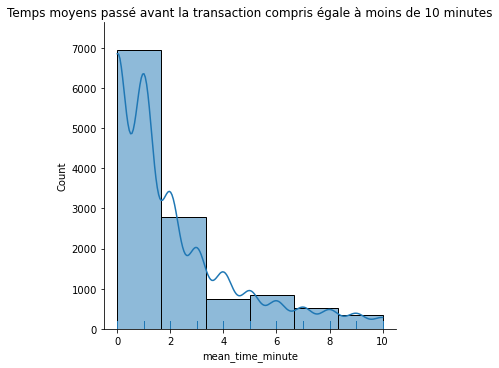

In [106]:
##### DATAVIZ ######
# Temps de Transactions moins d'une heure
mean_transaction_1h = time_mean_transaction.loc[round(time_mean_transaction['mean_time_minute']) <= 60]

# Temps de transactions moins de 10 minutes
mean_transaction_10minutes = mean_transaction_1h.loc[round(mean_transaction_1h['mean_time_minute']) <= 10]

sns.displot(time_mean_transaction['mean_time_hour'], bins=24, kde=True, rug=True, color='orange')
plt.title('Temps moyens passé avant la transaction')

sns.displot(mean_transaction_1h['mean_time_minute'], bins=6, kde=True, rug=True, color='red')
plt.title('Temps moyens passé avant la transaction compris égale à moins de 1 heure ')
          
sns.displot(mean_transaction_10minutes['mean_time_minute'], bins=6, kde=True, rug=True)
plt.title('Temps moyens passé avant la transaction compris égale à moins de 10 minutes')